In this notebook we apply pyMAISE to a 2D rod ejection data set. Our discussion is limited to the methods and models we apply and does not include an in-depth discussion of pyMAISE. For an in-depth tutorial, refer to the [MIT Reactor](https://pymaise.readthedocs.io/en/stable/examples/mit_reactor.html) notebook. For information on the pyMAISE methods used, refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

# NEACRP C1 Rod Ejection Accident

**Inputs**

- `rod_worth`: Reactivity worth of the ejected rod
- `beta`: Delayed neutron fraction 
- `h_gap`: Gap conductancce ($\frac{W}{m^2 \cdot K}$)
- `gamma_frac`: Direct heating fraction

**Outputs**

- `max_power`: Trandient peak power ($\% FP$)
- `burst_width`: Width of power burst ($s$)
- `max_TF`: Max fuel centerline temperature ($K$)
- `avg_Tcool`: Average coolant temperature at outlet ($K$)

The NEACRP C1 rod ejection accident (REA) data represents one benchmark for reactor transient analysis. The data set is used to find the relationship between the REA/reactor parameters and the power/thermal behavior of the system during/after the event. Therefore, the data set is constructed by perturbing the inputs listed above. The corresponding output results in values of interest to the safety analysis of the transient. The data were generated using deterministic simulations by the PARCS code, where the data set size includes 2000 samples. The goal is to use pyMAISE to build, tune, and compare various ML models' performance in predicting the transient outcomes based on the REA properties.

In [2]:
from pyMAISE.datasets import load_rea
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## Preprocessing

We define a pyMAISE regression problem and load the REA data.

In [3]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)
data, inputs, outputs = load_rea()

As stated the data set consists of 4 inputs:

In [4]:
inputs

<xarray.DataArray (index: 2000, variable: 4)>
array([[8.63781014e-03, 7.57558927e-03, 1.37279819e+04, 2.39566042e-02],
       [9.25495922e-03, 7.52915145e-03, 9.37021808e+03, 1.97072356e-02],
       [8.04631321e-03, 7.64737606e-03, 9.96254385e+03, 2.00446440e-02],
       ...,
       [8.72425595e-03, 7.47087165e-03, 1.10723962e+04, 1.53597012e-02],
       [9.11742702e-03, 7.49571772e-03, 1.08772638e+04, 1.73452589e-02],
       [8.35065112e-03, 7.63110349e-03, 1.34164011e+04, 1.71329041e-02]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'rod_worth' 'beta' 'h_gap' 'gamma_frac'

and 4 outputs with 2000 total data points:

In [5]:
outputs

<xarray.DataArray (index: 2000, variable: 4)>
array([[1.81210000e+02, 3.15000000e-01, 9.18300000e+02, 5.61119081e+02],
       [4.74590000e+02, 2.50000000e-01, 9.65200000e+02, 5.62030035e+02],
       [4.40830000e+01, 4.25000000e-01, 8.75700000e+02, 5.60194700e+02],
       ...,
       [2.55980000e+02, 2.90000000e-01, 9.36100000e+02, 5.61324028e+02],
       [4.27900000e+02, 2.55000000e-01, 9.57800000e+02, 5.61933922e+02],
       [9.69710000e+01, 3.80000000e-01, 8.98000000e+02, 5.60613781e+02]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'max_power' 'burst_width' 'max_Tf' 'avg_Tcool'

Prior to constructing any models we can get a surface understanding of the data set with a correlation matrix.

(<Figure size 800x800 with 2 Axes>, <Axes: >)

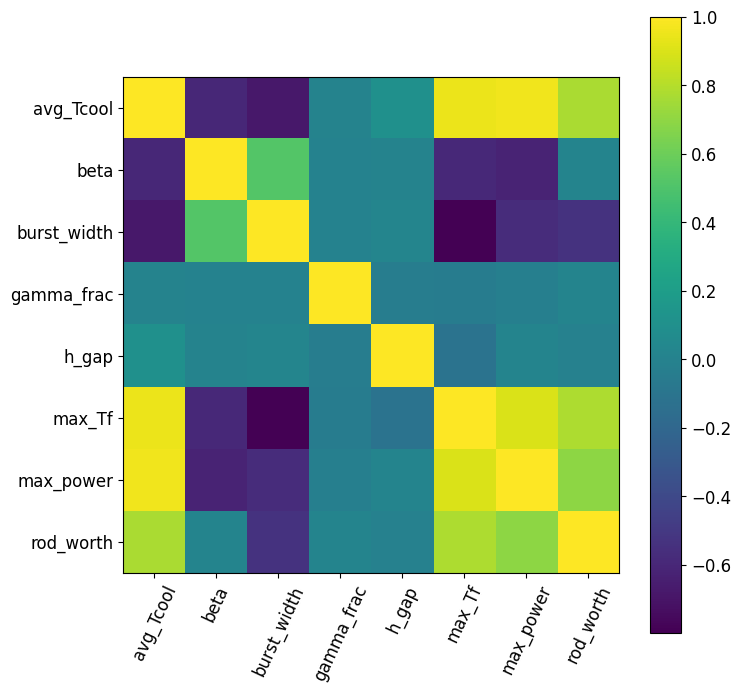

In [6]:
correlation_matrix(data)

There is a positive correlation between average coolant temperature and max fuel temperature, max power, and rod worth. The delayed neutron fraction and burst width have a negative correlation with max fuel temperature, max power, and rod worth.

We train/test split into 70%/30% and scale both inputs and outputs using min-max scaling to optimize model training.

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

We will examine the performance of 6 regression models in this data set:

- linear: `Linear`,
- lasso: `Lasso`,
- decision tree: `DT`,
- random forest: `RF`,
- k-nearest neighbors regression: `KN`,
- dense feedforward neural network: `FNN`.

For hyperparameter tuing, we initialize all classical models as scikit-learn defaults. For the FNN we define input and output layers with possible dropout layers. These layers include hyperparameter tuning of their number of nodes, use of sublayer, and the rate of dropout. The dense hidden layers include tuning of their depth.

In [8]:
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

We use random search with 200 iterations and 5 cross validation splits (1000 fits per model) for the classical models. The hyperparameter search space is defined for all but linear regression in which the default scikit-learn configuration will be tested. For the FNN we use Bayesian search with 50 iterations and 5 cross validation splits (250 fits total). This offers possible convergence on an optimal configuration without taking an excessive amount of time. Classical models tend to be simpler than neural networks so a large amount of random search iterations are possible.

In [9]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 50 Complete [00h 00m 26s]
r2_score: 0.6991452194962674

Best r2_score So Far: 0.9892360785811016
Total elapsed time: 00h 17m 53s
Hyperparameter tuning took 35.667927686373396 minutes to process.


Here is the convergence plot of the Bayesian search:

(0.0, 1.0)

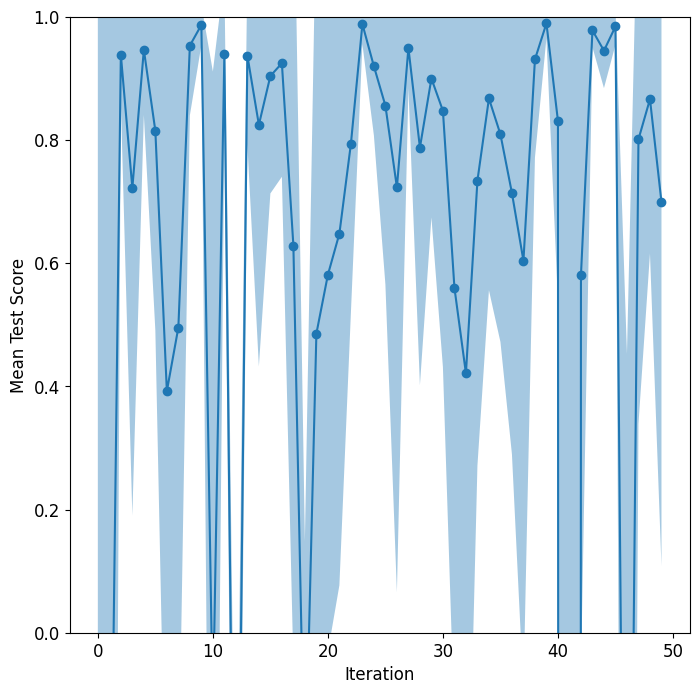

In [27]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])

## Post-processing

We can now pass these parameter configurations to the `pyMAISE.PostProcessor` for model evaluation. We increase the neural network epochs to 200 to improve their fit.

In [11]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"epochs": 200},
    },
    yscaler=yscaler,
)

To compare the performance of these models we compute 4 metrics for both the training and testing data: 

- mean squared error `MSE` $=\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2$, 
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y_i}|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y_i})^2}{\sum^n_{i = 1}(y_i - \bar{y_i})^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\hat{y}$ is the model predicted outcome, and $n$ is the number of observations. The averaged performance metrics are shown below.

In [12]:
postprocessor.metrics(y="max_power")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
22,FNN,"{'Dense_input_0_units': 380, 'Dense_input_0_su...",0.999325,3.376658,29.929292,5.470767,0.998831,3.748839,48.777031,6.984055
24,FNN,"{'Dense_input_0_units': 343, 'Dense_input_0_su...",0.999427,3.242341,25.391058,5.038954,0.997900,3.538577,87.633191,9.361260
23,FNN,"{'Dense_input_0_units': 61, 'Dense_input_0_sub...",0.998613,3.600090,61.512204,7.842972,0.997167,3.639287,118.249444,10.874256
21,FNN,"{'Dense_input_0_units': 309, 'Dense_input_0_su...",0.997627,8.764668,105.203381,10.256870,0.995909,9.245286,170.709661,13.065591
11,RF,"{'criterion': 'absolute_error', 'max_features'...",0.998621,4.189655,61.145456,7.819556,0.991682,9.963117,347.134614,18.631549
25,FNN,"{'Dense_input_0_units': 382, 'Dense_input_0_su...",0.993667,12.212756,280.815828,16.757560,0.991469,13.646220,356.036513,18.868930
12,RF,"{'criterion': 'absolute_error', 'max_features'...",0.998110,4.806882,83.826638,9.155689,0.990550,10.553297,394.362116,19.858553
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.996053,5.942448,175.010044,13.229136,0.989002,10.405386,458.976369,21.423734
14,RF,"{'criterion': 'squared_error', 'max_features':...",0.996559,6.304034,152.564794,12.351712,0.988838,11.457849,465.813136,21.582705
13,RF,"{'criterion': 'absolute_error', 'max_features'...",0.996294,6.245927,164.332363,12.819219,0.988391,10.672437,484.466283,22.010595


For max power all but linear and lasso regression has testing $R^2$ greater than 0.95. The FNN and random forest models performed exceptionally with $R^2$ greater than 0.99.

In [13]:
postprocessor.metrics(y="burst_width")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
23,FNN,"{'Dense_input_0_units': 61, 'Dense_input_0_sub...",0.985233,0.008745,0.000259,0.016104,0.988523,0.008304,0.000152,0.012339
22,FNN,"{'Dense_input_0_units': 380, 'Dense_input_0_su...",0.988813,0.005033,0.000196,0.014017,0.983895,0.005210,0.000214,0.014617
24,FNN,"{'Dense_input_0_units': 343, 'Dense_input_0_su...",0.973191,0.009205,0.000471,0.021699,0.978481,0.007935,0.000285,0.016896
25,FNN,"{'Dense_input_0_units': 382, 'Dense_input_0_su...",0.962884,0.009873,0.000652,0.025531,0.972656,0.009383,0.000363,0.019046
14,RF,"{'criterion': 'squared_error', 'max_features':...",0.983000,0.004994,0.000299,0.017279,0.965422,0.006894,0.000459,0.021418
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.977664,0.005272,0.000392,0.019806,0.964367,0.006572,0.000473,0.021742
11,RF,"{'criterion': 'absolute_error', 'max_features'...",0.993420,0.003256,0.000116,0.010750,0.963863,0.006737,0.000479,0.021896
12,RF,"{'criterion': 'absolute_error', 'max_features'...",0.989684,0.003769,0.000181,0.013460,0.958523,0.006831,0.000550,0.023458
7,DT,"{'max_depth': 7, 'max_features': 4, 'min_sampl...",0.975691,0.009041,0.000427,0.020662,0.954600,0.011185,0.000602,0.024542
21,FNN,"{'Dense_input_0_units': 309, 'Dense_input_0_su...",0.973814,0.006880,0.000460,0.021445,0.953148,0.006731,0.000622,0.024931


For burst width k-nearest neightbors, decision tree, lasso, and linear regression largely struggled. K-nearest neighbors is overfit. Interestingly, there is one performing defision tree (both training and testing $R^2$ greater than 0.95) which is slightly overfit. The top performers was the FNN and random forest models; however, the FNN was more consistent between training and testing.

In [14]:
postprocessor.metrics(y="max_Tf")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
23,FNN,"{'Dense_input_0_units': 61, 'Dense_input_0_sub...",0.999526,0.491132,0.619136,0.786852,0.998216,0.543955,2.126439,1.458232
24,FNN,"{'Dense_input_0_units': 343, 'Dense_input_0_su...",0.998341,1.203813,2.167884,1.472373,0.996588,1.242643,4.067003,2.016681
21,FNN,"{'Dense_input_0_units': 309, 'Dense_input_0_su...",0.998385,0.984026,2.110219,1.452659,0.995850,1.100288,4.946751,2.224129
22,FNN,"{'Dense_input_0_units': 380, 'Dense_input_0_su...",0.993978,2.341316,7.869572,2.805276,0.991782,2.355243,9.796239,3.129894
25,FNN,"{'Dense_input_0_units': 382, 'Dense_input_0_su...",0.991290,2.464087,11.383776,3.373985,0.988529,2.548371,13.674686,3.697930
11,RF,"{'criterion': 'absolute_error', 'max_features'...",0.997850,1.121527,2.809675,1.676208,0.986327,2.605750,16.299328,4.037243
12,RF,"{'criterion': 'absolute_error', 'max_features'...",0.996897,1.346328,4.055170,2.013745,0.984904,2.689654,17.996218,4.242195
14,RF,"{'criterion': 'squared_error', 'max_features':...",0.993829,1.946313,8.065334,2.839953,0.982386,2.985048,20.997267,4.582277
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.984577,2.868272,20.156537,4.489603,0.982167,2.732209,21.258263,4.610668
5,Lasso,{'alpha': 0.00028508869576073897},0.983896,2.793054,21.046321,4.587627,0.981322,2.633254,22.265743,4.718659


Max fuel temperature is a more linear label with all models performing well with $R^2$ greater than 0.95. Once again the FNN and random forest models were the top performing models.

In [15]:
postprocessor.metrics(y="avg_Tcool")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
22,FNN,"{'Dense_input_0_units': 380, 'Dense_input_0_su...",0.999176,0.017645,0.000471,0.021710,0.999052,0.017699,0.000527,0.022963
24,FNN,"{'Dense_input_0_units': 343, 'Dense_input_0_su...",0.998383,0.021133,0.000926,0.030423,0.998148,0.020369,0.001030,0.032088
21,FNN,"{'Dense_input_0_units': 309, 'Dense_input_0_su...",0.998364,0.028993,0.000936,0.030597,0.998091,0.029323,0.001062,0.032583
23,FNN,"{'Dense_input_0_units': 61, 'Dense_input_0_sub...",0.997841,0.033157,0.001236,0.035153,0.997567,0.033837,0.001353,0.036779
25,FNN,"{'Dense_input_0_units': 382, 'Dense_input_0_su...",0.997357,0.032703,0.001512,0.038888,0.997175,0.033500,0.001571,0.039637
11,RF,"{'criterion': 'absolute_error', 'max_features'...",0.998423,0.020313,0.000903,0.030045,0.991159,0.045224,0.004916,0.070117
12,RF,"{'criterion': 'absolute_error', 'max_features'...",0.997830,0.023659,0.001242,0.035241,0.990469,0.046898,0.005300,0.072800
14,RF,"{'criterion': 'squared_error', 'max_features':...",0.995994,0.032382,0.002293,0.047882,0.988848,0.050950,0.006201,0.078749
13,RF,"{'criterion': 'absolute_error', 'max_features'...",0.995520,0.034321,0.002564,0.050636,0.988596,0.051361,0.006341,0.079632
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.994985,0.034201,0.002870,0.053571,0.987595,0.053151,0.006898,0.083055


Average coolant temperature was also well predicted by all models.

In [16]:
postprocessor.metrics()[["Model Types", "Train R2", "Test R2"]]

,Model Types,Train R2,Test R2
23,FNN,0.995303,0.995368
22,FNN,0.995323,0.993390
24,FNN,0.992336,0.992779
25,FNN,0.986299,0.987457
21,FNN,0.992048,0.985750
11,RF,0.997078,0.983258
14,RF,0.992345,0.981374
12,RF,0.995630,0.981111
15,RF,0.990121,0.980508
13,RF,0.992375,0.977650


Overall the top performing models are the FNNs some of which are above 0.99 $R^2$ for both training and testing data sets. Linear and lasso regression were the worst performing models.

Below are the hyperparameter configurations of each of the top performing models.

In [17]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.00028508869576073897

Model Types: DT
max_depth: 46
max_features: None
min_samples_leaf: 1
min_samples_split: 4

Model Types: RF
criterion: absolute_error
max_features: 6
min_samples_leaf: 1
min_samples_split: 3
n_estimators: 128

Model Types: KN
leaf_size: 18
n_neighbors: 3
p: 2
weights: distance

Model Types: FNN
Dense_input_0_units: 61
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.49025906468398583
Dense_hidden_num_layers: 3
Adam_learning_rate: 0.00034026486812900825
Dense_hidden_0_units: 248
Dense_hidden_0_sublayer: None
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.5687649199865222
Dense_hidden_1_units: 188
Dense_hidden_1_sublayer: None
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.4383744609330325
Dense_hidden_2_units: 42
Dense_hidden_2_sublayer: None
Dense_hidden_2_sublayer_Dropout_hidden_0_rate: 0.5430141865119306
batch_size: 8



We can visualize the performance of each model with diagonal validation plots. These plots show the predicted output to the actual output. The performance of FNN is apparent with the spread close around $y= x$. Random forest, k-nearest neighbors, and decision tree performed relatively well on all outputs. Burst width is evidently the most difficult to predict for all the models.

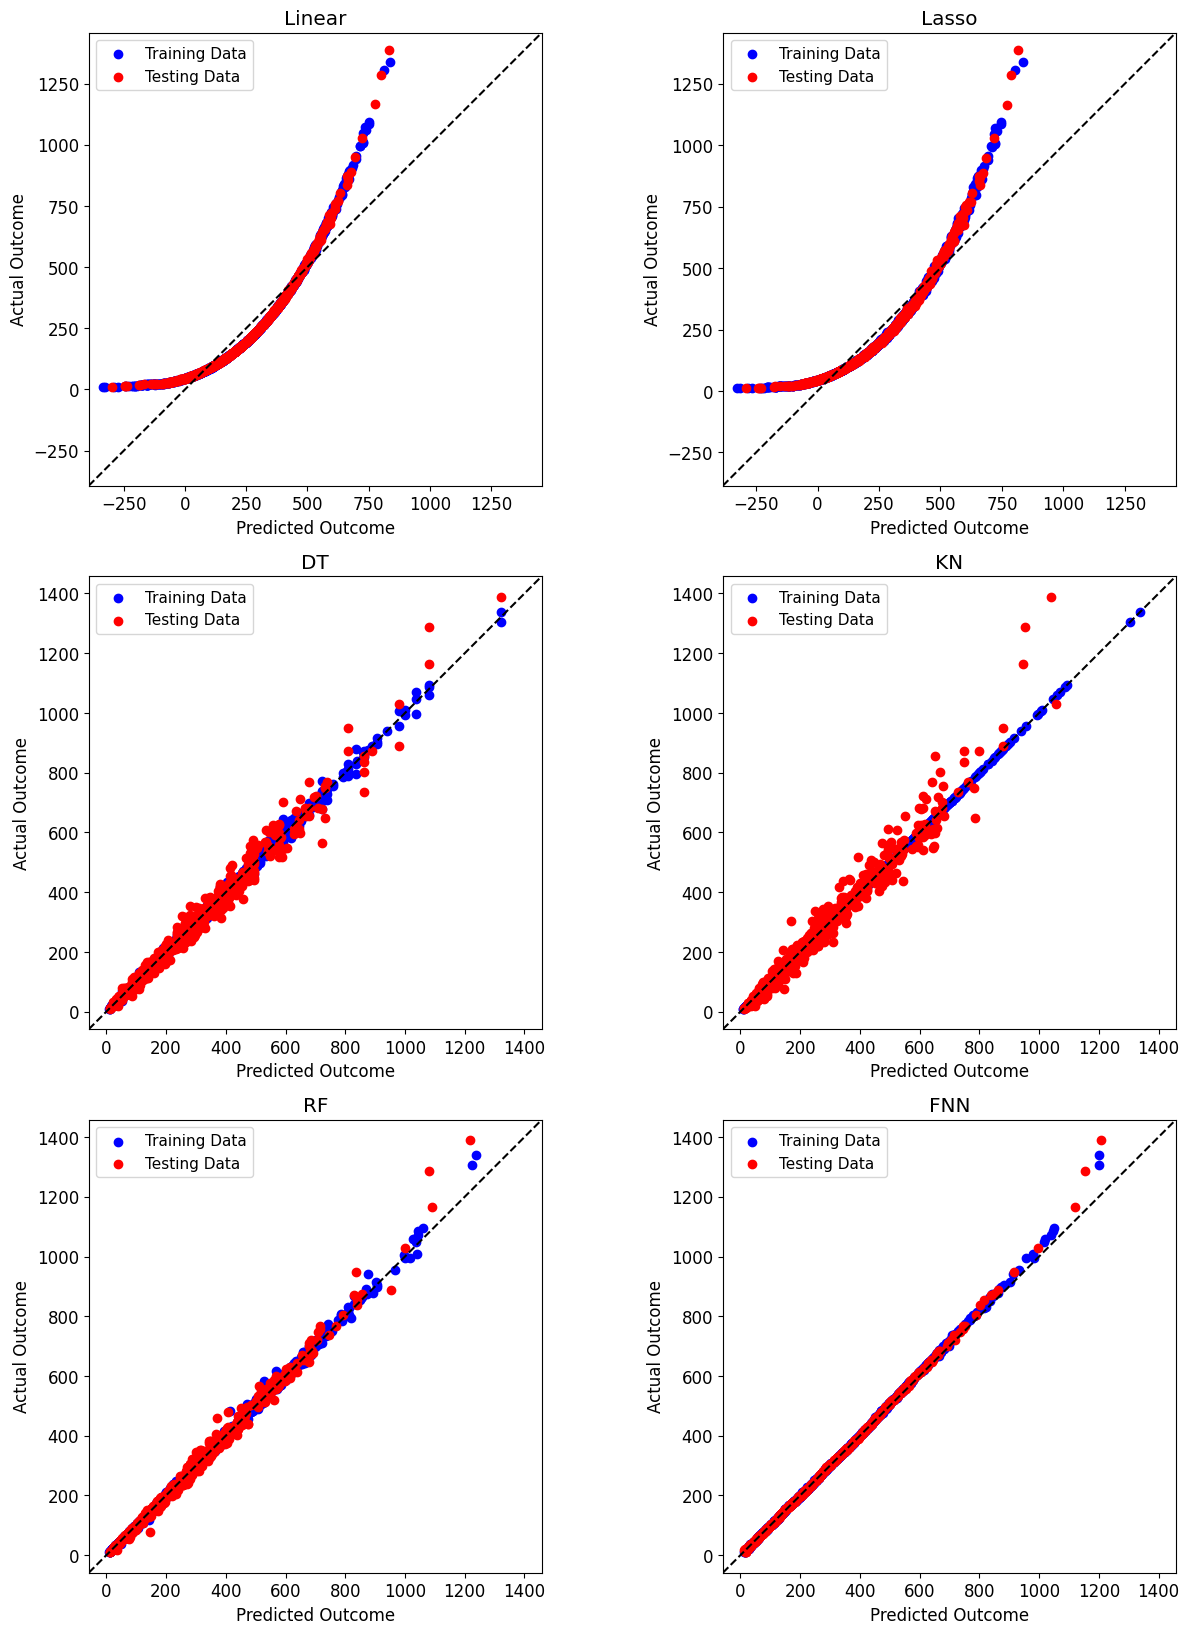

In [28]:
def performance_plot(meth, output):
    models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
    fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(15,20))
    for i in range(models.shape[0]):
        for j in range(models.shape[1]):
            plt.sca(axarr[i, j])
            axarr[i, j] = meth(model_type=models[i, j], y=[output])
            axarr[i, j].set_title(models[i, j])


performance_plot(postprocessor.diagonal_validation_plot, "max_power")

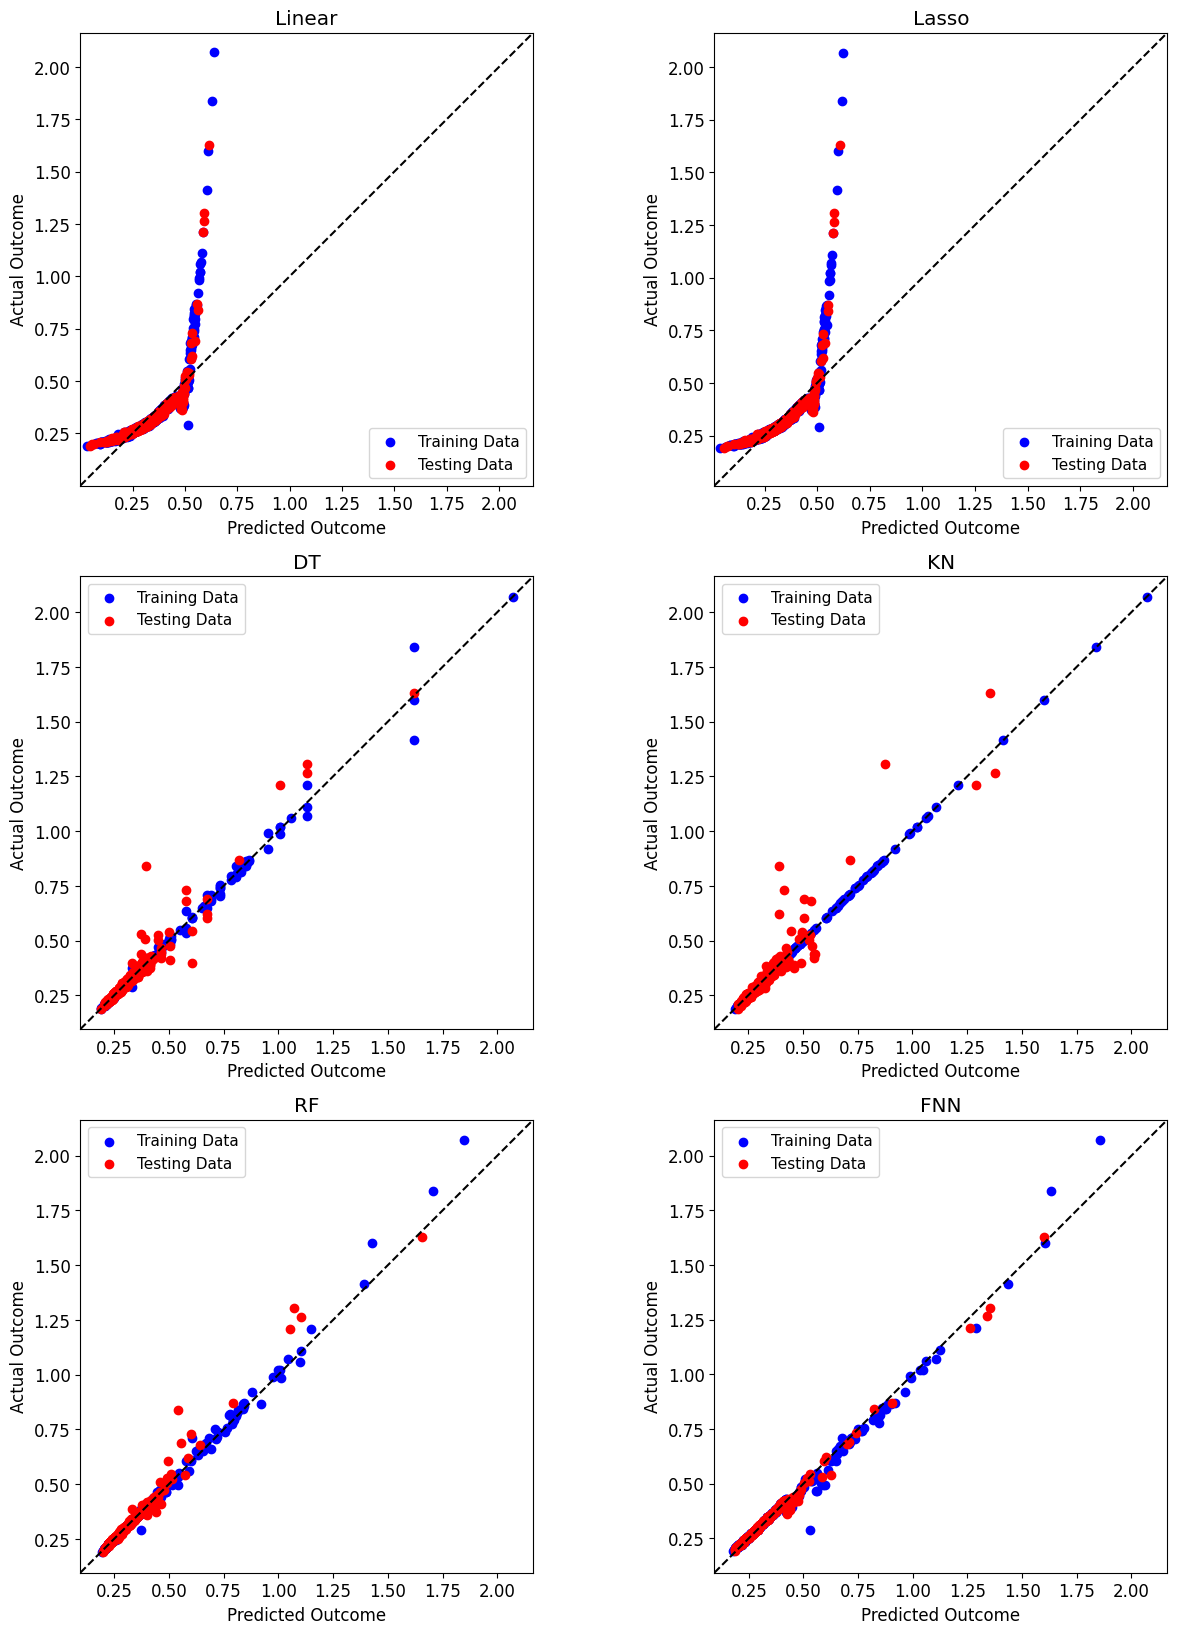

In [29]:
performance_plot(postprocessor.diagonal_validation_plot, "burst_width")

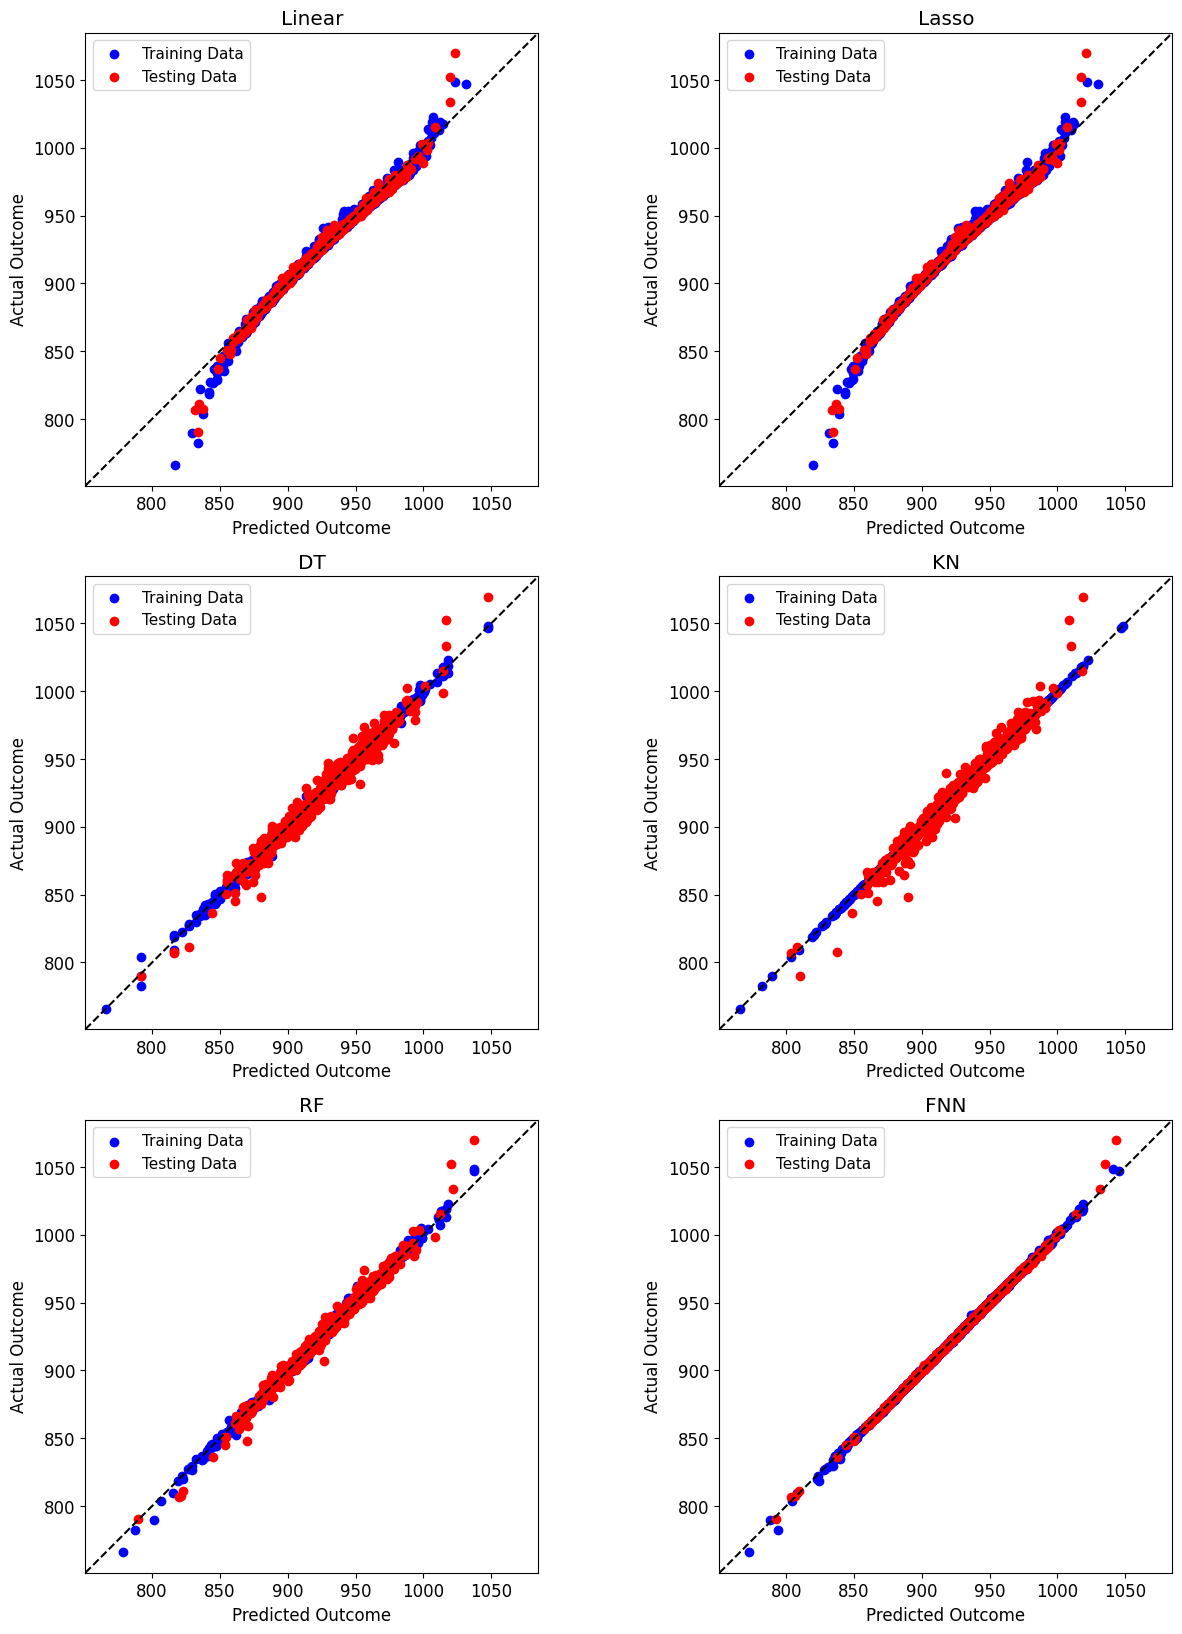

In [30]:
performance_plot(postprocessor.diagonal_validation_plot, "max_Tf")

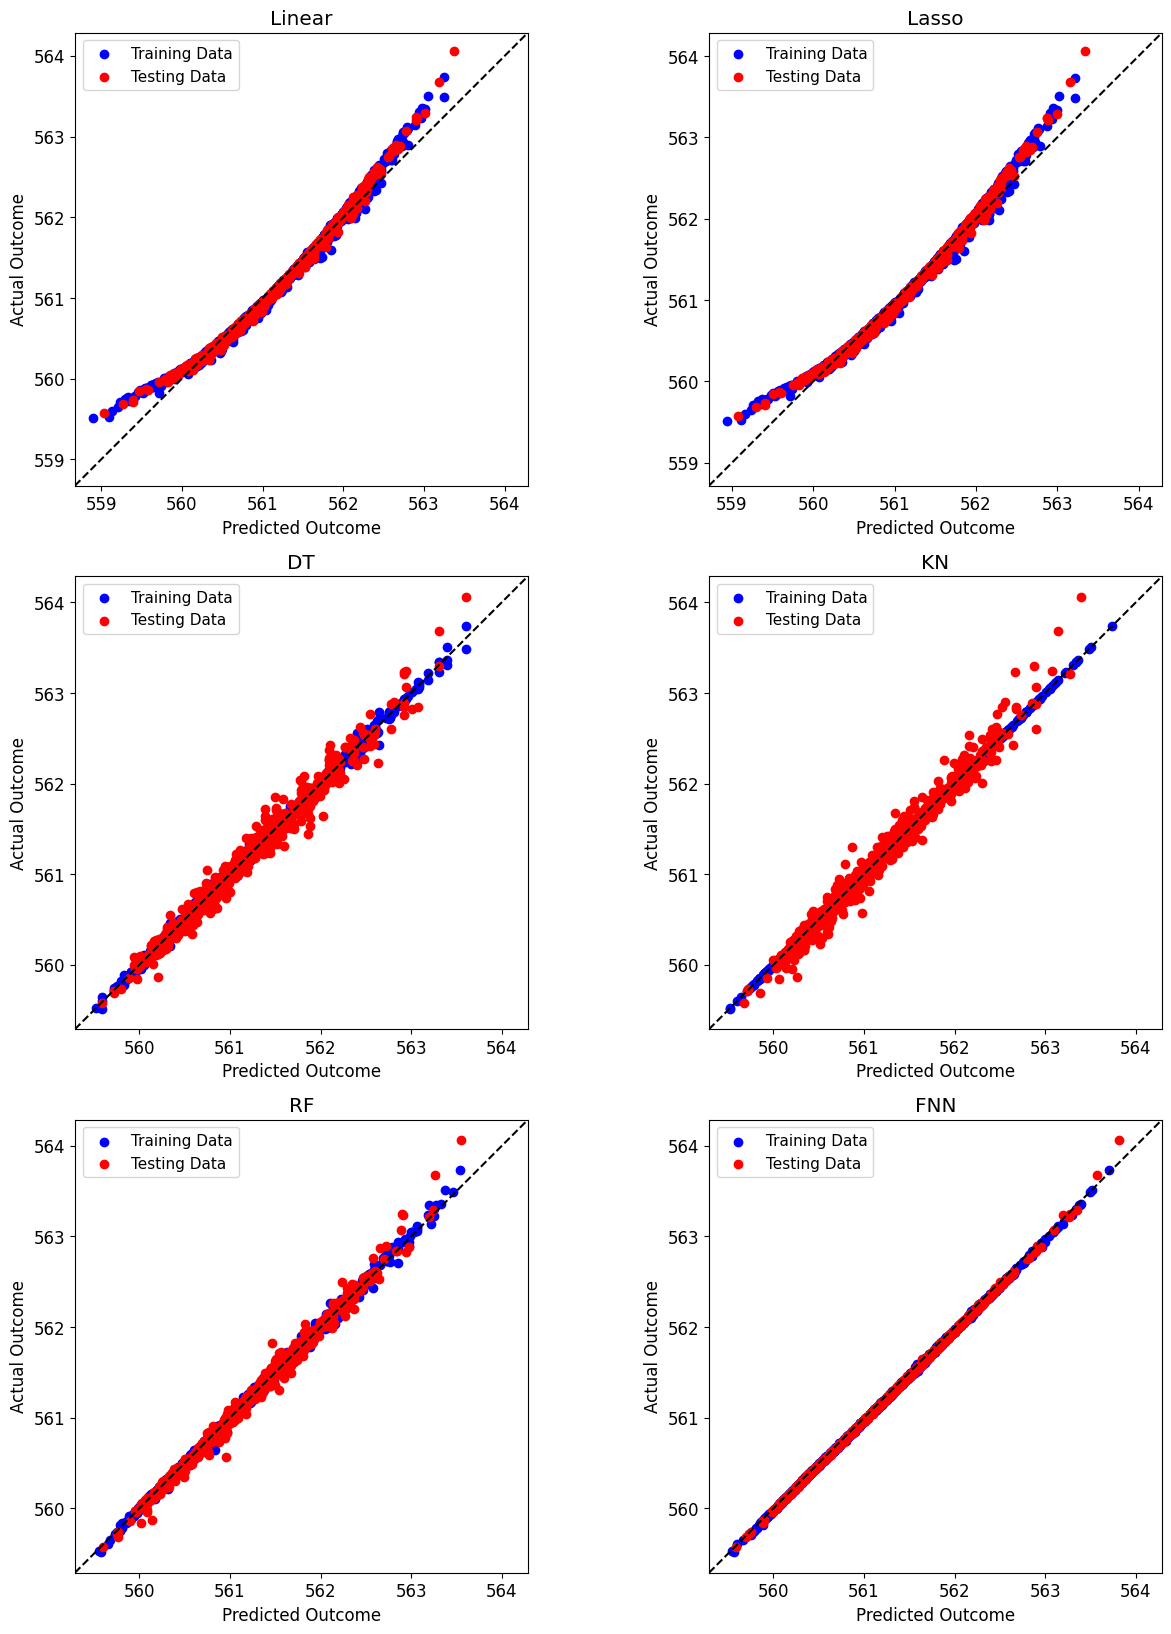

In [31]:
performance_plot(postprocessor.diagonal_validation_plot, "avg_Tcool")

The validation plots for all outputs are given below. Based on the scaling of the $y$-axis we can see that the FNNs performed the best. Both the diagonal validation and validation plots agree with the performance metrics presented above.

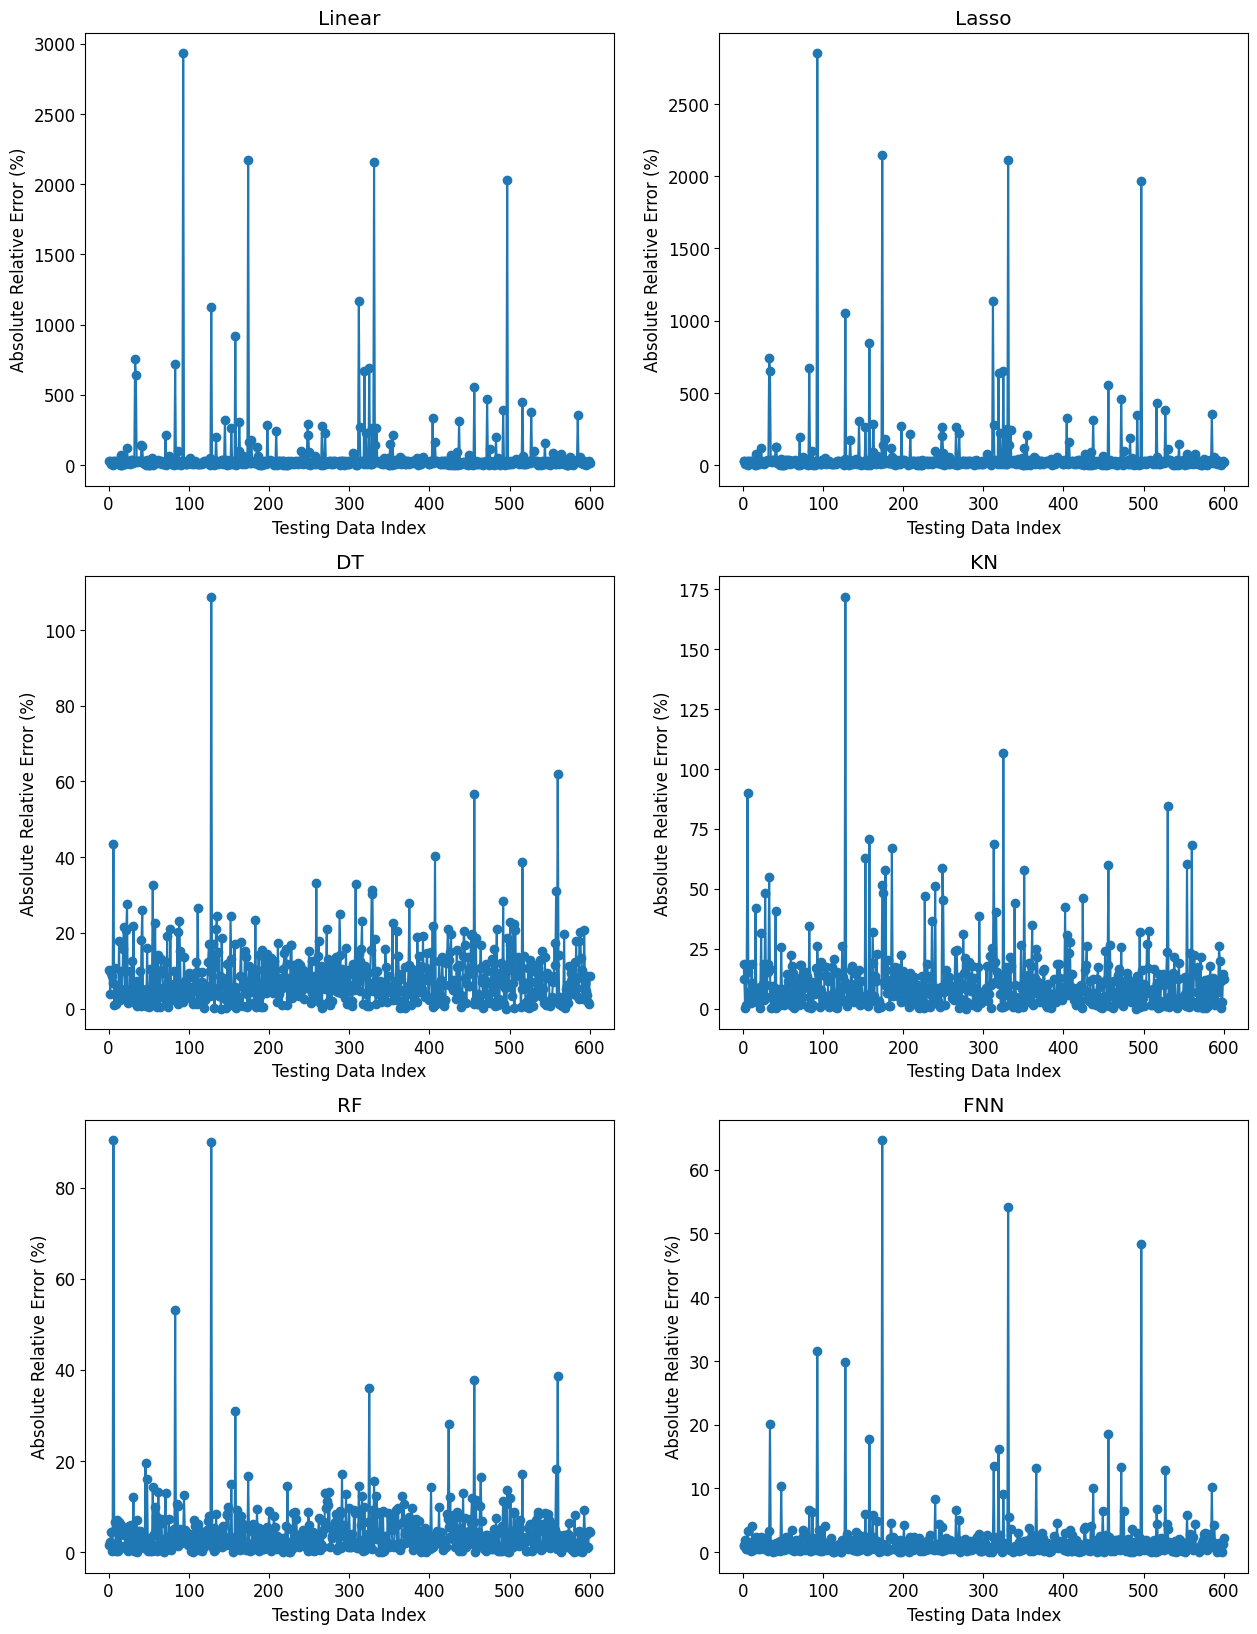

In [32]:
performance_plot(postprocessor.validation_plot, "max_power")

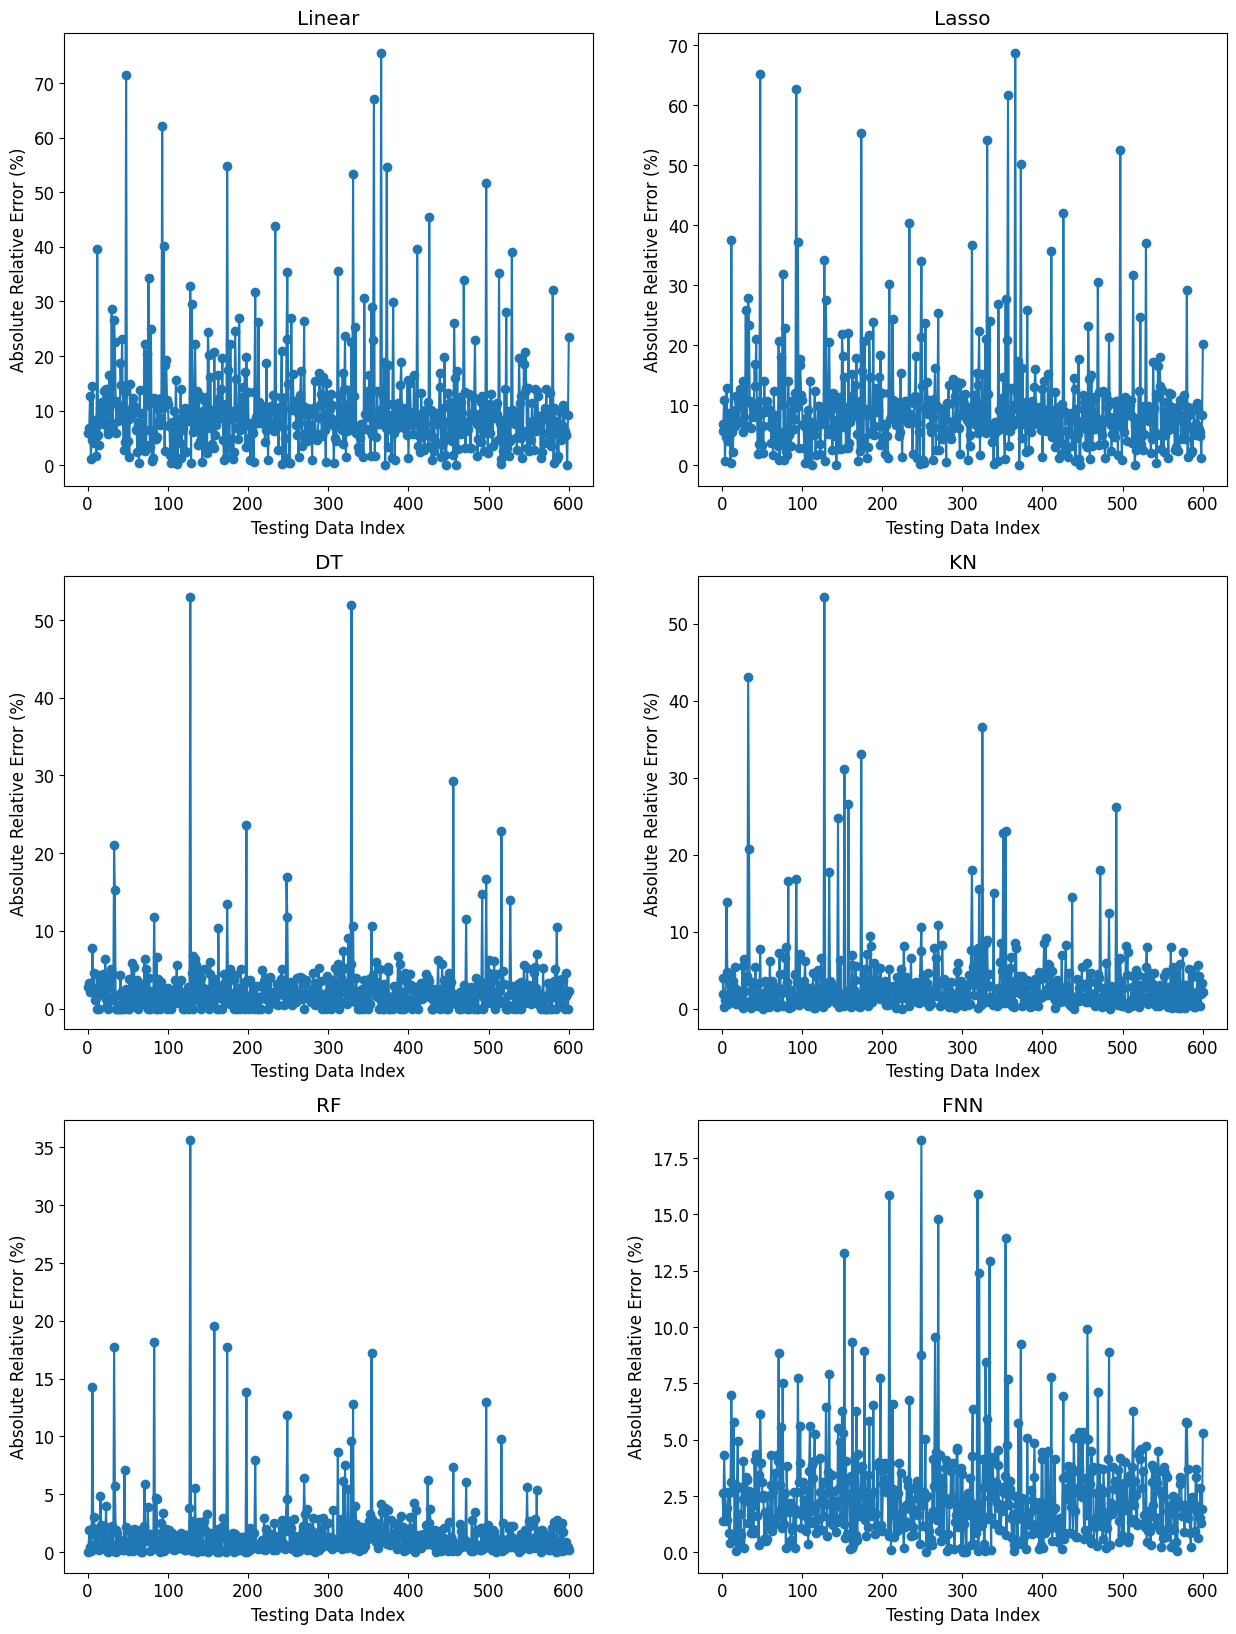

In [33]:
performance_plot(postprocessor.validation_plot, "burst_width")

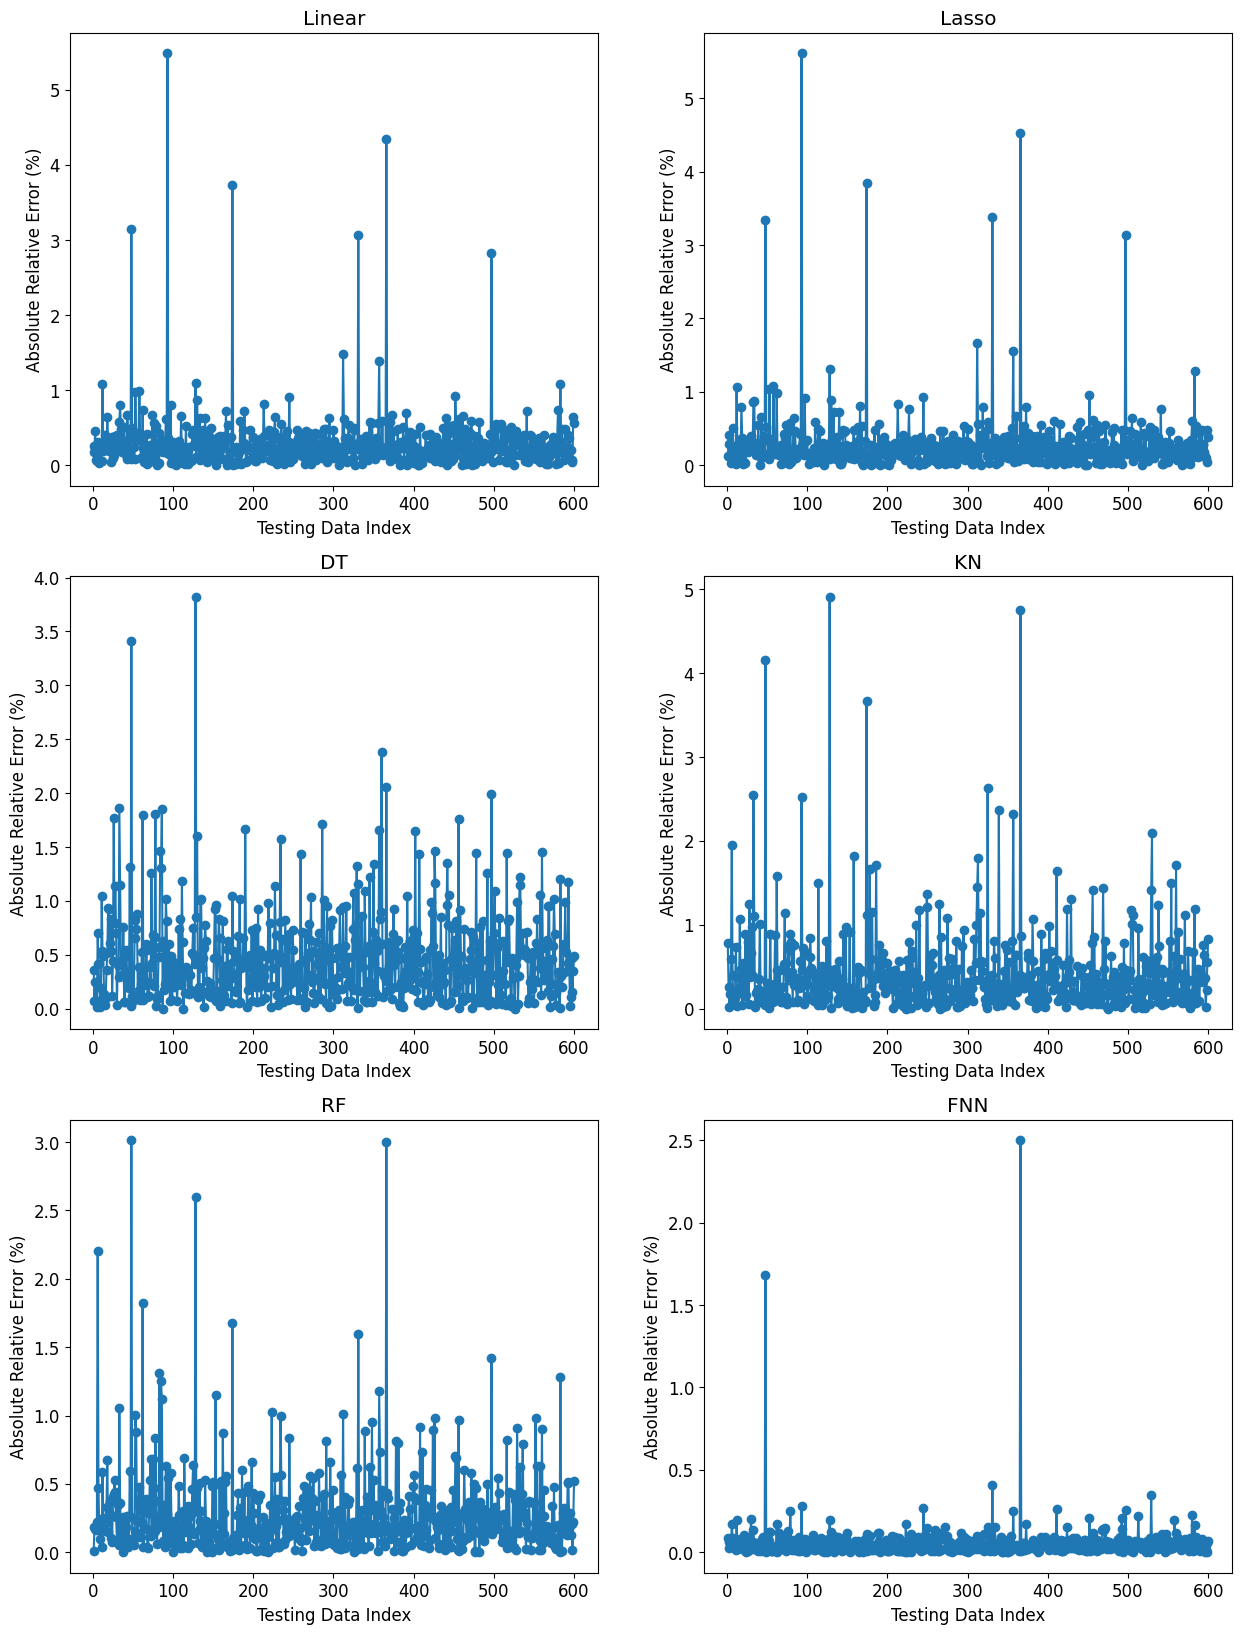

In [34]:
performance_plot(postprocessor.validation_plot, "max_Tf")

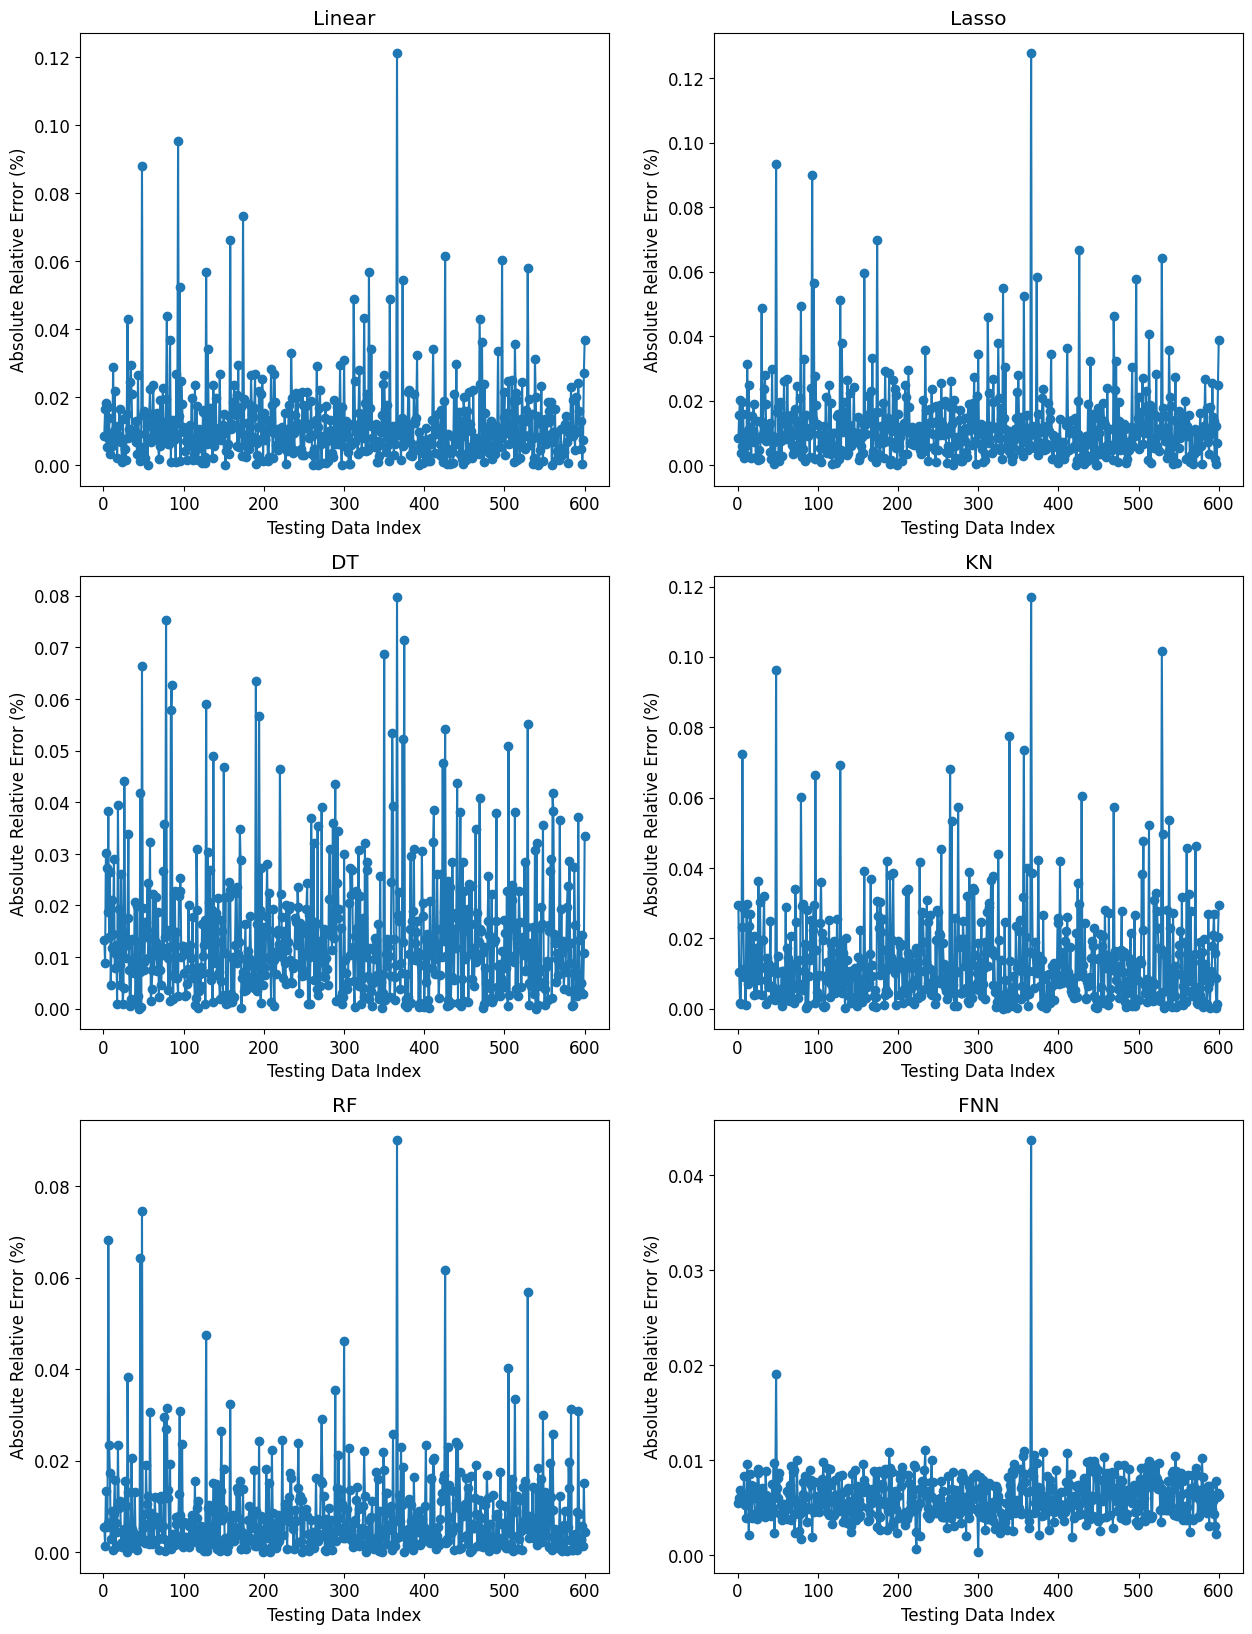

In [35]:
performance_plot(postprocessor.validation_plot, "avg_Tcool")

Finally, the most learning curve for the most performant FNN is shown below. It shows no overfitting as the validation curve follows the training curve closely.

<Axes: xlabel='Epoch', ylabel='Loss'>

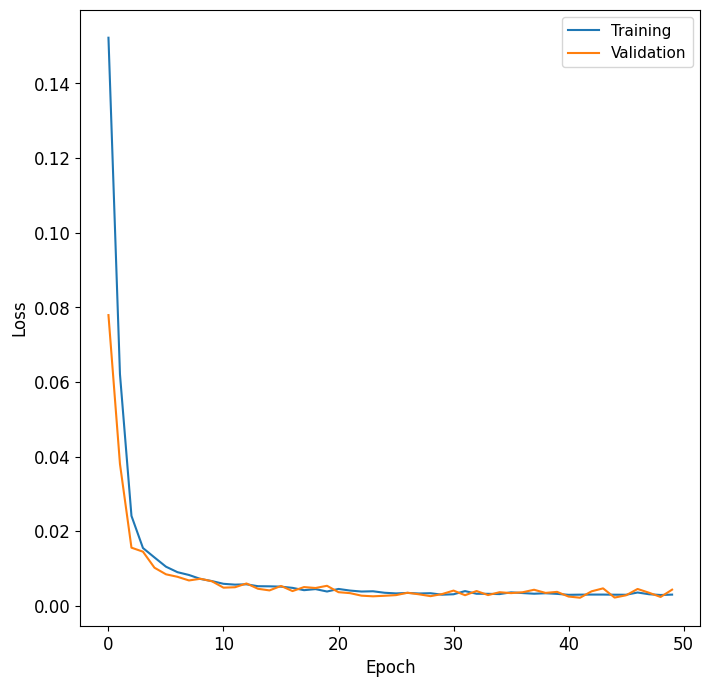

In [26]:
postprocessor.nn_learning_plot()

![pyMAISElogo.png](../_images/pyMAISElogo.png)